In [3]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime as dt
%matplotlib inline

In [4]:
current_date = dt.datetime.now()
#test which november to start on
if current_date.month >= 11:
    #if month is november or december the year should be the same year
    start_date = '{year}-11-01'.format(year=current_date.year)
else:
    #if not take the previous november
    start_date = '{year}-11-01'.format(year=current_date.year - 1)
end_date = current_date.strftime('%Y-%m-%d')


In [11]:
station_id = 'GHCND:USW00024285'
#api noaa token can be found here:
#https://www.ncdc.noaa.gov/cdo-web/token
noaa_token = 'zYKUphEjBWILVGlSxQOHxzGFRFNKaQdj'
#this url provides a list of stations
#url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&limit=1000&datacategoryid=TEMP&offset=1000&extent=42.047165,-124.378791,48.955117,-117.148889'
url = 'http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND'\
      '&datacategoryid=TEMP'\
      '&stationid={}'\
      '&startdate={}'\
      '&enddate={}'\
      '&limit=1000'.format(station_id, start_date, end_date)
print (url)
# token as required by NOAA feed, you have to register for this
headers = {'token': noaa_token}
#send query string and header payload 
http_response = requests.get(url, headers = headers)
#dump json into python dictionary
print (http_response.json())
#response = http_response.json()

http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datacategoryid=TEMP&stationid=GHCND:USW00024285&startdate=2017-11-01&enddate=2018-01-22&limit=1000


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [9]:
#convert to pandas dataframe 
data = pd.DataFrame(response['results'])
#filter results down to daily average
data = data[data['datatype']=='TAVG']
#temperature data from feed given in 10ths degrees C, divide by 10 to give whole degrees 
data['value'] = data['value'] / 10

In [10]:
#chill function
def FunChill(temp, aC = 3.13, bC=10, cC=10.93, dC=2.10, eC = 3.10):
    try:
        chill = aC * (((temp + bC)/cC)**dC) * np.exp(-(((temp + bC)/cC)**eC))
    except:
        chill = np.nan
    if chill > 1:
        chill = 1
    if (temp <= -20 or temp >= 16):
        chill = 0
    return chill

#force function
def FunForce(temp, aF = 4.49, bF = -0.63):
    force = 1 / (1 + np.exp(aF + bF*temp))
    return force

In [11]:
#apply the chill function and force function to the temperate
data['FunChill'] = data['value'].apply(FunChill)
data['FunForce'] = data['value'].apply(FunForce)

#cumulative sum for the calculated chill and force columns, forward fill missing data
data['FunChill.cumsum'] = data['FunChill'].cumsum().ffill()
data['Force.cumsum'] = data['FunForce'].cumsum().ffill()

Text(0.5,1,'Chilling and forcing accumulations from 2017-11-01 through 2018-01-20')

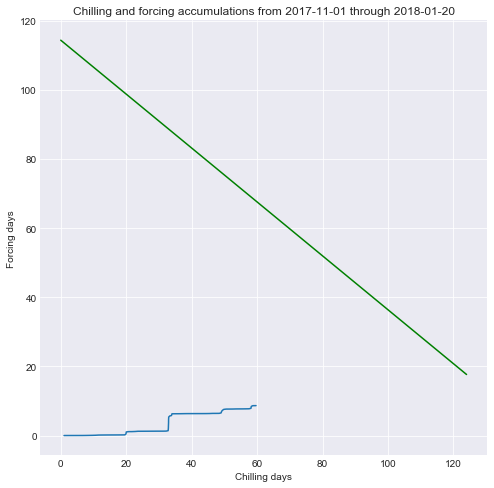

In [12]:
def plot_model(model, x_range, color='green'):  
    """
    This function graphs the model
    """
    x = np.array(x_range)  
    y = model(x)
    ax.plot(x, y, color=color, label=str(model))  


#extend the model by this many chill units
extend_xaxis_model = 100
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(data['FunChill.cumsum'], data['Force.cumsum'])
plot_model(lambda x: 114.4-(0.78*x), range(0,125))
ax.set_xlabel('Chilling days')
ax.set_ylabel('Forcing days')
ax.set_title('Chilling and forcing accumulations from {} through {}'.format(start_date, end_date))

